<a href="https://colab.research.google.com/github/tbacha/DMML2019_Team_Apple/blob/master/SBB/project_1/SimuDuTuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install shap

In [26]:
!pip install eli5

In [53]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

In [28]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [29]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39


In [31]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


In [32]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 8.33 s, sys: 19.4 ms, total: 8.35 s
Wall time: 8.46 s


In [33]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

In [34]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


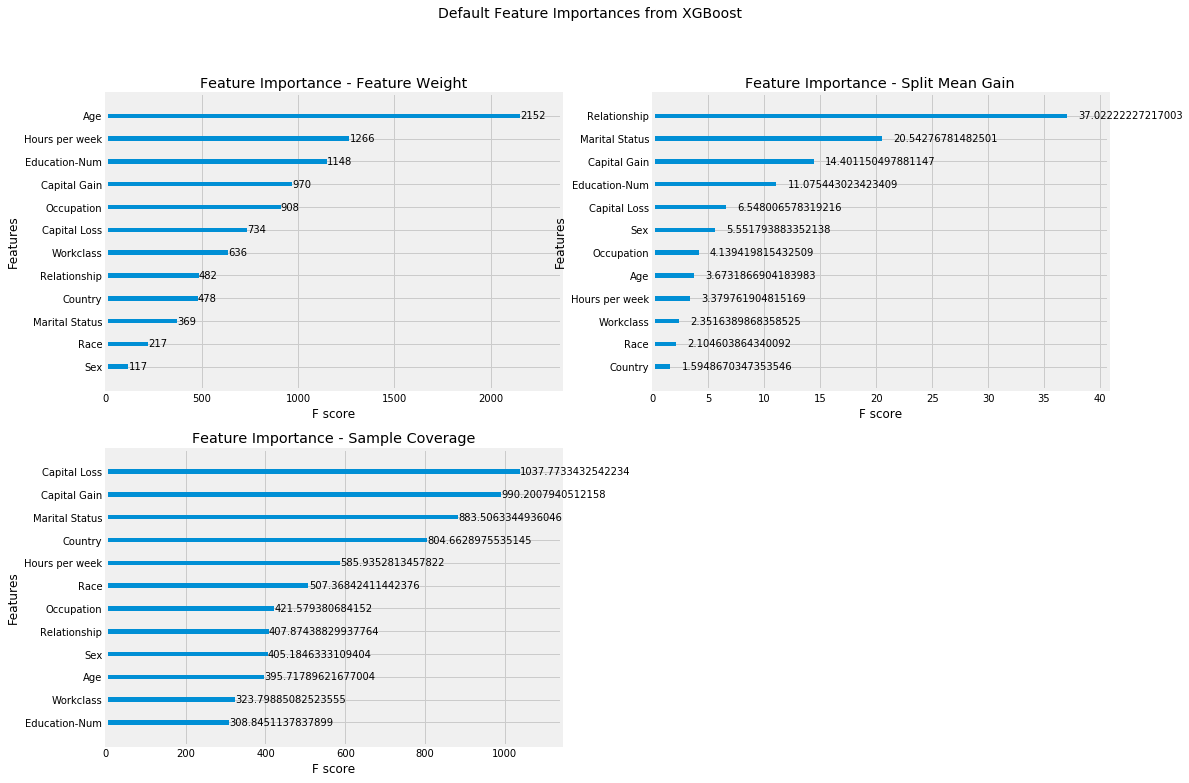

In [35]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

In [36]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.3294,Relationship
0.1828,Marital Status
0.1281,Capital Gain
0.0985,Education-Num
0.0583,Capital Loss
0.0494,Sex
0.0368,Occupation
0.0327,Age
0.0301,Hours per week
0.0209,Workclass


In [38]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True)

Actual Label: 0
Predicted Label: 0


In [39]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label: 1
Predicted Label: 1


In [40]:
!pip install skater

In [0]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test, training_labels=y_test, 
                             feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=['$50K or less', 'More than $50K'])

2020-03-04 13:49:29,377 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 13 seconds

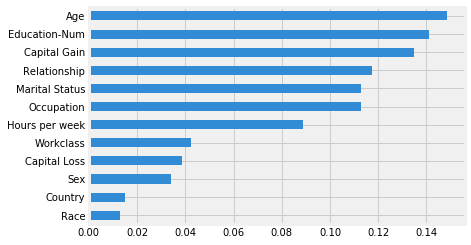

In [17]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_samples=23000)

2020-03-04 13:50:18,762 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 34 seconds

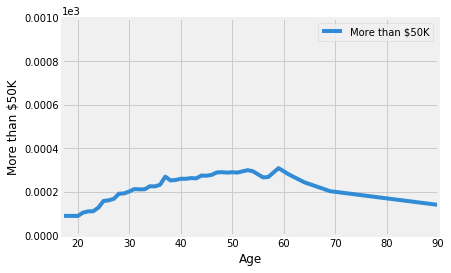

In [18]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 


2020-03-04 13:51:47,780 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 12 seconds

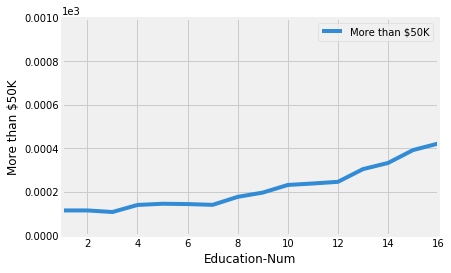

In [19]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

2020-03-04 13:52:29,548 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 4 seconds

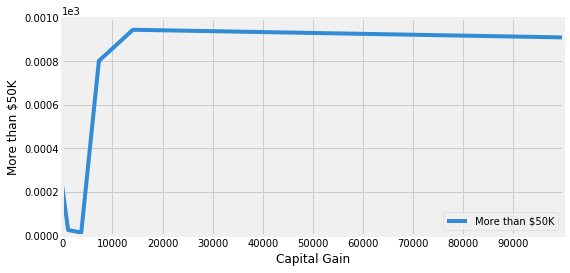

In [20]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

In [42]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], 
          axis=1).drop_duplicates()

,Relationship,Relationship
0,Not-in-family,1
1,Husband,0
4,Wife,5
12,Own-child,3
17,Unmarried,4
74,Other-relative,2


2020-03-04 13:53:37,809 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 4 seconds

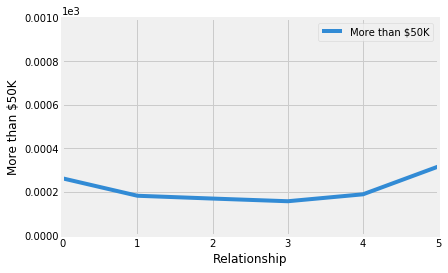

In [22]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

2020-03-04 13:54:41,413 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1136/1136] grid cells ████████████████████ Time elapsed: 1272 seconds

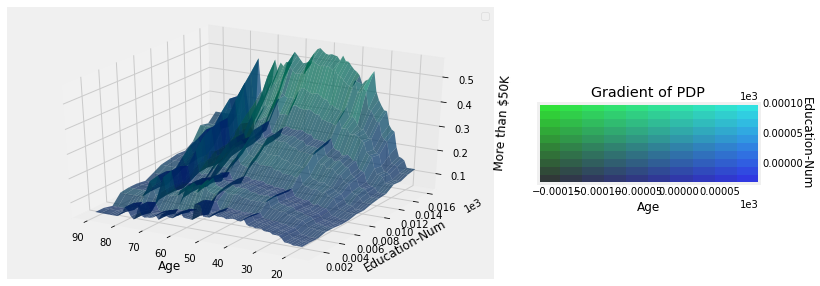

In [23]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)


In [0]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)


In [45]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2020-03-04 14:44:38,848 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2020-03-04 14:44:38,851 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2020-03-04 14:44:40,200 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2020-03-04 14:44:40,225 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.889; oracle score 0.898


0.009

In [46]:
pd.DataFrame([('X'+str(idx), feature) 
                   for (idx, feature) in enumerate(data.columns)]).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
1,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country


In [0]:
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG

graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

In [48]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=surrogate_predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8273
Precision: 0.8333
Recall: 0.8273
F1 Score: 0.8299

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      7455
           1       0.62      0.68      0.65      2314

    accuracy                           0.83      9769
   macro avg       0.76      0.78      0.77      9769
weighted avg       0.83      0.83      0.83      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6504   951
        1        736  1578


In [49]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: -1.3625857


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.209206,-0.003895,-0.073927,-1.078541,-0.645259,-0.517731,-0.002871,-0.421329,-0.144742,-0.036394,-0.568053,-0.004587
1,0.354368,-0.262398,-0.483883,0.586233,0.307967,1.194750,0.017408,-0.216272,-0.108322,-0.048158,-0.095782,0.017657
2,-0.525650,0.030637,0.970991,0.360480,0.528695,0.603971,-0.103895,0.050630,-0.176231,-0.087669,0.509656,0.024573
3,-0.426095,0.076188,0.576406,-1.108961,-0.517884,-0.522604,0.028896,-0.359869,-0.142805,-0.057430,-0.250736,0.023183
4,-0.503867,-0.159754,-0.129339,-0.547773,-0.049194,-0.414065,-0.019701,0.128197,-3.685364,-0.031033,0.781617,0.001285


In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

In [58]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

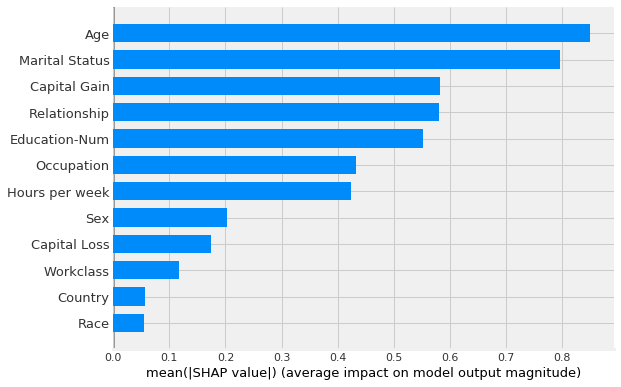

In [59]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

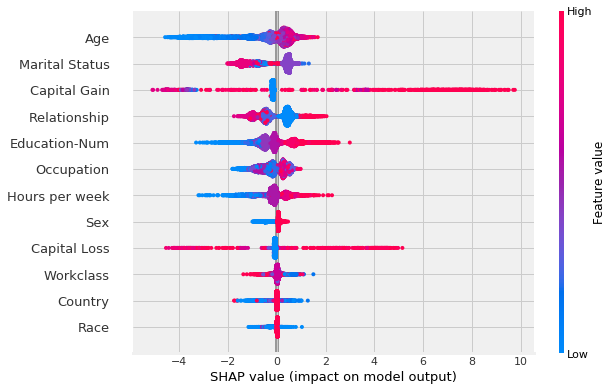

In [60]:
shap.summary_plot(shap_values, X_test)

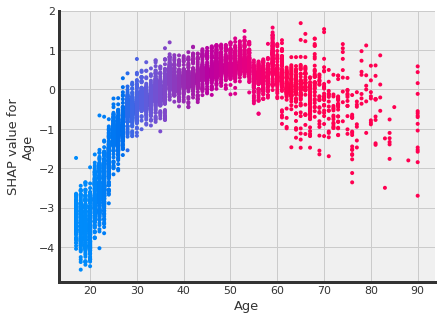

In [61]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

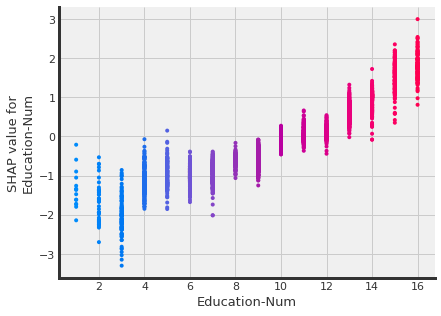

In [62]:

shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

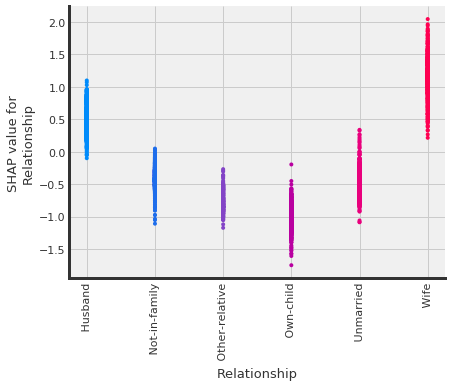

In [63]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

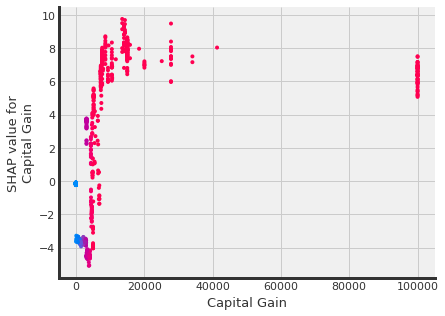

In [64]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

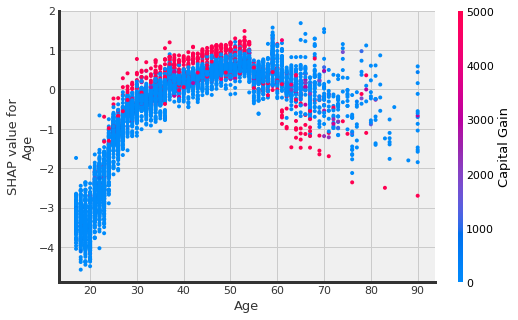

In [65]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)